# Operational Satellites
### Satellite database was assembled by the Union of Concerned Scientists (UCS)
* Current as of **1 Sept 2017**
* The database is a listing of the more than 1000 operational satellites currently in orbit around Earth
* https://www.ucsusa.org/nuclear-weapons/space-weapons/satellite-database#.WqHhO3UbPIo
* Data science perform by *Brendan Lane*

## Importing Data

In [324]:
# Load modules
import pandas as pd
import numpy as np
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale=2)

In [2]:
# Load data
df = pd.read_csv('UCS_Satellite_Database.csv')

## Data Munging

In [3]:
# Remove columns with missing, incomplete, or not meaningful data
cols = ['Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40',
        'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46',
        'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
        'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58',
        'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64',
        'Country/Org of UN Registry', 'Unnamed: 27', 'Source Used for Orbital Data', 'Source',
        'Source.1', 'Source.2', 'Source.3', 'Source.4', 'Source.5', 'Comments', 'Power (watts)',
        'Contractor', 'Country of Contractor', 'Detailed Purpose', 'Country/Org of UN Registry',
        'Power (watts)', 'COSPAR Number', 'NORAD Number', 'Dry Mass (kg.)', 'Expected Lifetime']

df.drop(cols, axis='columns', inplace=True)

In [4]:
# Dropped over a hundred rows of missing satellite mass data from data table
df.dropna(subset=['Launch Mass (kg.)', 'Longitude of GEO (degrees)'], axis='rows', inplace=True)

In [5]:
# No duplicated rows
df[df.duplicated()]

Name of Satellite, Alternate Names  \
1365  SB-WASS 3-6 (Space Based Wide Area Surveillanc...   
1367  SB-WASS 3-7 (Space Based Wide Area Surveillanc...   
1369  SB-WASS 3-8 (Space Based Wide Area Surveillanc...   

     Country of Operator/Owner                                Operator/Owner  \
1365                       USA  National Reconnaissance Office (NRO)/US Navy   
1367                       USA  National Reconnaissance Office (NRO)/US Navy   
1369                       USA  National Reconnaissance Office (NRO)/US Navy   

         Users            Purpose Class of Orbit       Type of Orbit  \
1365  Military  Earth Observation            LEO  Non-Polar Inclined   
1367  Military  Earth Observation            LEO  Non-Polar Inclined   
1369  Military  Earth Observation            LEO  Non-Polar Inclined   

      Longitude of GEO (degrees) Perigee (km) Apogee (km)  Eccentricity  \
1365                         0.0        1,012       1,203       0.01280   
1367                         0.0        1,014       1,099       0.00572   
1369                         0.0        1,009       1,204       0.01300   

      Inclination (degrees) Period (minutes) Launch Mass (kg.) Date of Launch  \
1365                   63.4            107.4             6,500      9/13/2012   
1367                   63.4            107.4             6,500      10/8/2015   
1369                   63.4            107.4             6,500       3/1/2017   

         Launch Site Launch Vehicle  
1365  Vandenberg AFB        Atlas 5  
1367  Vandenberg AFB        Atlas 5  
1369  Vandenberg AFB        Atlas 5

In [273]:
# Nations active in space
df['Country of Operator/Owner'] = df['Country of Operator/Owner'].apply(lambda x: x.replace(' ', ''))
df['Country of Operator/Owner'].unique()

array(['Finland', 'Denmark', 'Multinational', 'USA', 'Germany', 'Norway',
       'Russia', 'Kazakhstan', 'Algeria', 'Spain', 'Canada', 'Uruguay',
       'Argentina', 'China', 'ESA', 'Japan', 'Luxembourg', 'India',
       'Singapore', 'Azerbaijan', 'Turkey', 'Belarus', 'Israel',
       'Bangladesh', 'Brazil', 'Indonesia', 'Bulgaria', 'UnitedKingdom',
       'SouthKorea', 'Italy', 'Netherlands', 'Switzerland',
       'UnitedArabEmirates', 'Mexico', 'France', 'Taiwan', 'Greece',
       'Australia', 'Laos', 'Lithuania', 'Mongolia', 'Malaysia',
       'Nigeria', 'Egypt', 'SouthAfrica', 'Sweden', 'Pakistan', 'Peru',
       'Ukraine', 'Belgium', 'SaudiArabia', 'Iran', 'Slovakia', 'Chile',
       'Thailand', 'Iraq', 'Bolivia', 'Austria', 'Venezuela', 'Latvia',
       'Vietnam', 'CzechRepublic'], dtype=object)

## Preprocessing

In [279]:
# One-hot encoding countries
cvec = CountVectorizer(binary=True)
df_countries = pd.DataFrame(cvec.fit_transform(df['Country of Operator/Owner'].replace(' ', '')).todense(), columns=cvec.get_feature_names())

In [275]:
# Replaces multiple countries with 'Multinational'
df['Country of Operator/Owner'] = df['Country of Operator/Owner'].apply(lambda x: 'Multinational' if '/' in x else x)

In [9]:
# Cleaning the 'Users" columns
map_dict = {
    'Civil': 'Civil',
    'Commercial': 'Commercial',
    'Military': 'Military',
    'Government': 'Government',
    'Military ': 'Military',
    'Military/Civil': 'Military/Civil',
    'Commercial/Military': 'Military/Commercial',
    'Military/Commercial': 'Military/Commercial',
    'Civil/Government': 'Government/Civil',
    'Government/Civil': 'Government/Civil',
    'Commercial/Government': 'Government/Commercial',
    'Government/Commercial': 'Government/Commercial',
    'Commerical': 'Commercial',
    'Military/Government': 'Government/Military',
    'Government/Military': 'Government/Military',
    'Commercial/Government/Military': 'Commercial/Government/Military'
}

df.Users = df.Users.map(map_dict)

In [10]:
# One-hot encoding 'Users'
df_users = pd.DataFrame(cvec.fit_transform(df.Users).todense(), columns=cvec.get_feature_names())

In [11]:
# One-hot encoding 'Class of Orbit'
df['Class of Orbit'] = df['Class of Orbit'].apply(lambda x: x.strip())
df_orbit_class = pd.DataFrame(cvec.fit_transform(df['Class of Orbit']).todense(), columns=cvec.get_feature_names())

In [12]:
# One-hot encoding 'Type of Orbit'
orbs = df['Type of Orbit'].dropna()
orbs = orbs.apply(lambda x: x.replace(' ', ''))
orbs = orbs.apply(lambda x: x.replace('-', ''))
df_orbit_type = pd.DataFrame(cvec.fit_transform(orbs).todense(), columns=cvec.get_feature_names())

In [13]:
# One-hot encoding 'Purpose'
df.Purpose = df.Purpose.apply(lambda x: x.replace(' ', ''))
df_purpose = pd.DataFrame(cvec.fit_transform(df.Purpose).todense(), columns=cvec.get_feature_names())

In [14]:
# Converting columns to floats
df['Perigee (km)'] = df['Perigee (km)'].apply(lambda x: float(x.replace(',', '')))
df['Apogee (km)'] = df['Apogee (km)'].apply(lambda x: float(x.replace(',', '')))
df['Period (minutes)'] = df['Period (minutes)'].apply(lambda x: x.replace(',', ''))
df['Period (minutes)'] = df['Period (minutes)'].apply(lambda x: x.replace('8 days', '11520'))
df['Period (minutes)'] = df['Period (minutes)'].apply(lambda x: float(x))
df['Launch Mass (kg.)'] = df['Launch Mass (kg.)'].apply(lambda x: x.replace(',', ''))
df['Launch Mass (kg.)'] = df['Launch Mass (kg.)'].apply(lambda x: x.replace('+', ''))
df['Launch Mass (kg.)'] = df['Launch Mass (kg.)'].apply(lambda x: float(x))

In [15]:
# Extracting month, day, and year
date = [x.split('/') for x in df['Date of Launch']]
df.loc[:, 'Month'] = [x[0] for x in date]
df.loc[:, 'Day'] = [x[1] for x in date]
df.loc[:, 'Year'] = [x[2] for x in date]

In [16]:
# One-hot encoding 'Month'
df_month = pd.get_dummies(df.Month, prefix='Month')
# One-hot encoding 'Day'
df_day = pd.get_dummies(df.Day, prefix='Day')
# One-hot encoding 'Year'
df_year = pd.get_dummies(df.Year, prefix='Year')
# One-hot encoding 'Launch Sites'
df_launchsite = pd.get_dummies(df['Launch Site'])

In [17]:
# Classifies satellite based on mass, https://en.wikipedia.org/wiki/Small_satellite
mass_class = []
for weight in df['Launch Mass (kg.)']:
    if weight <= 1:
        mass_class.append('pico')
    elif weight <= 10:
        mass_class.append('nano')
    elif weight <= 100:
        mass_class.append('micro')
    elif weight <= 500:
        mass_class.append('mini')
    elif weight <= 1000:
        mass_class.append('medium')
    else:
        mass_class.append('large')

df_weight_class = pd.DataFrame(mass_class, columns=['Class'])

## Exploratory Data Analysis
### Satellite Masses

In [326]:
# Histograph function
def hist_plot(data, title, xlabel, bins=None):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color='#000000', alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Satellites')
    plt.show()

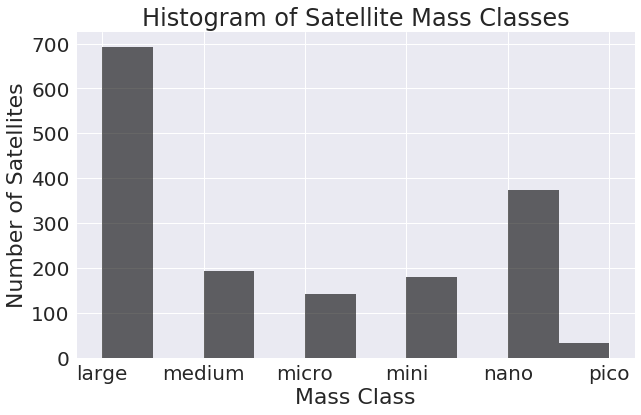

In [327]:
# Satellite mass class histogram
data = df_weight_class
hist_plot(data, 'Histogram of Satellite Mass Classes', 'Mass Class')

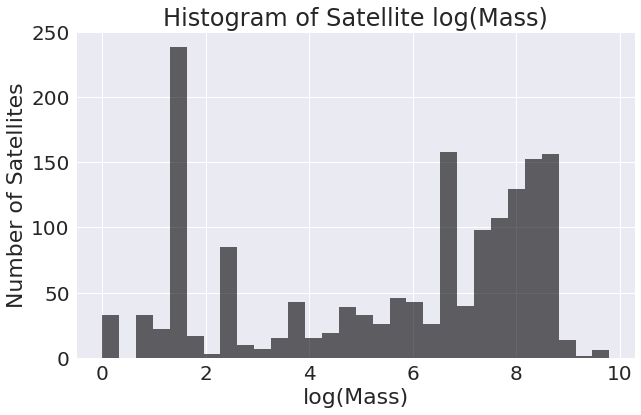

In [341]:
# Satellite mass class histogram
data = np.log(df['Launch Mass (kg.)'])
hist_plot(data, 'Histogram of Satellite log(Mass)', 'log(Mass)', 30)

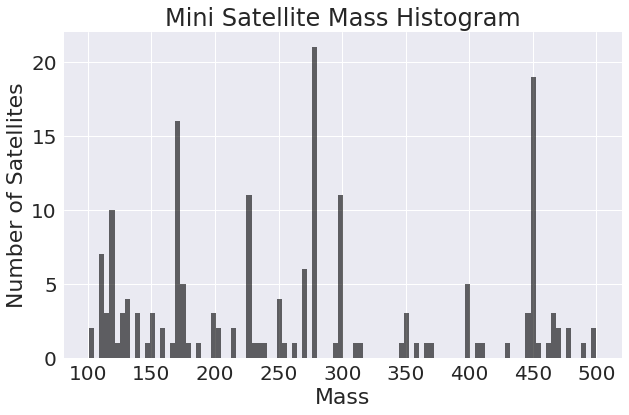

In [347]:
# Mini satellite mass class histogram
data = df[(df['Launch Mass (kg.)'] <= 500) & (df['Launch Mass (kg.)'] > 100)]['Launch Mass (kg.)']
hist_plot(data, 'Mini Satellite Mass Histogram', 'Mass', 100)

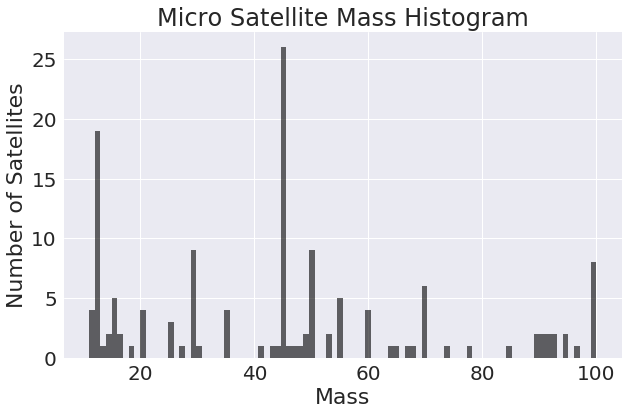

In [345]:
# Micro satellite mass class histogram
data = df[(df['Launch Mass (kg.)'] <= 100) & (df['Launch Mass (kg.)'] > 10)]['Launch Mass (kg.)']
hist_plot(data, 'Micro Satellite Mass Histogram', 'Mass', 90)

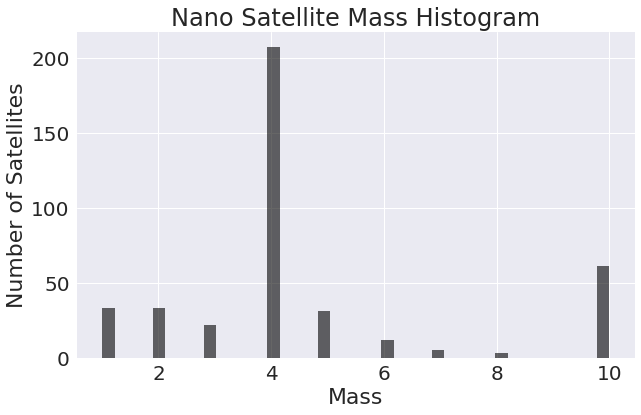

In [349]:
# Nano satellite mass class histogram
data = df[df['Launch Mass (kg.)'] <= 10]['Launch Mass (kg.)']
hist_plot(data, 'Nano Satellite Mass Histogram', 'Mass', 40)

### Countries with Satellites

In [353]:
# Number of satellites per country
n_sats = [sum(df_countries[col]) for col in df_countries]
country_sat_pair = list(zip(df_countries.columns, n_sats))

In [354]:
# Sort results
country_sat_pair.sort(key=lambda x: x[1], reverse=True)
country = [c[0].capitalize() for c in country_sat_pair]
n_sats = [c[1] for c in country_sat_pair]

###### *Right-click* bar chart and 'Open image in new tab' and zoom in

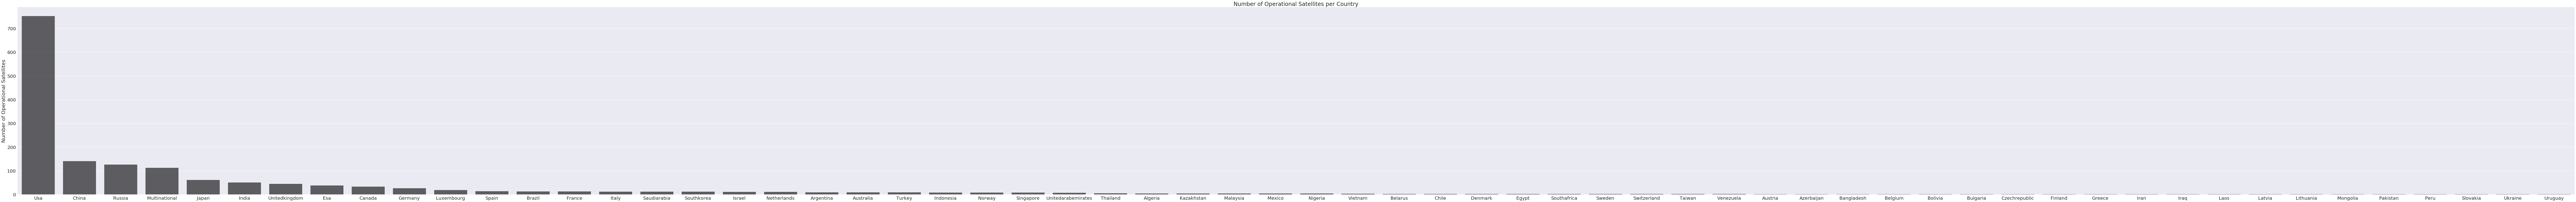

In [348]:
# Plotting results
plt.figure(figsize=(200, 15))
sns.barplot(country, n_sats, color='#000000', alpha=0.6)
plt.title('Number of Operational Satellites per Country')
plt.ylabel('Number of Operational Satellites')
plt.show()

How many satellites mass per country?

In [356]:
df['Launch Mass (kg.)'].shape

(1614,)

In [357]:
df_countries.shape

(1614, 62)

In [ ]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('fit', aosdjff())
])
pipe.fit(data)
pipe.predict(data)

In [352]:
params = {'fit__n_neighbors': range(1,25)}

In [ ]:
gs = GridSeartchCV(pipe, params)

In [ ]:
gs.fit()

### Clustering

In [73]:
# Assign clustering features
data = [df['Period (minutes)'].reset_index(), df_purpose.reindex()]
# Create data frame
data = pd.concat(data, axis='columns')

print('Null count: {}'.format(data.isnull().sum().sum()))
print('Data rows:  {}'.format(data.shape[0]))
print('Data cols:  {}'.format(data.shape[1]))

Null count: 0
Data rows:  1614
Data cols:  14


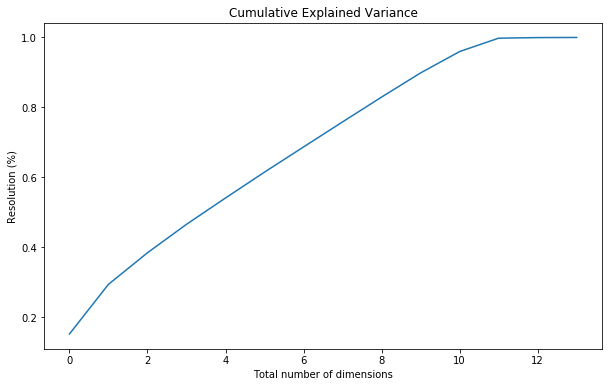

In [107]:
# Scaling the data
ss = StandardScaler()
data_ss = ss.fit_transform(data)

# Principal Component Analysis (PCA)
pca = PCA()
data_pca = pca.fit_transform(data_ss)
# Plot PCA explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Total number of dimensions')
plt.ylabel('Resolution (%)')
plt.title('Cumulative Explained Variance')
plt.show()

In [29]:
def plot_clusters(df, title):
    fig, ax = plt.subplots(figsize=(10,10))
    
    colors = plt.cm.Spectral(np.linspace(0, 1, len(df.label.unique())))
    
    for label, color in zip(df.label.unique(), colors):
        X = df[df.label == label]
        ax.scatter(X.iloc[:,0], X.iloc[:,1], s=70, 
                   color=color, label=label, alpha=0.9)
        
    ax.set_title(title, fontsize=20)
    ax.legend(loc='lower right')
    
    plt.show()

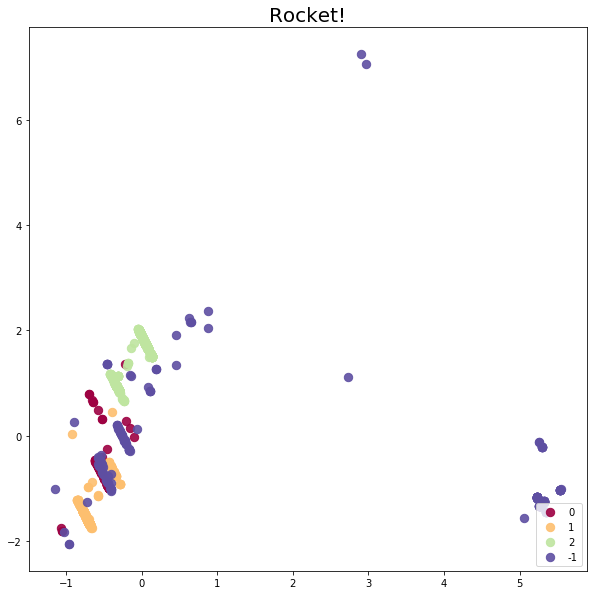

In [48]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=120)
XX = pd.DataFrame(X)
cluster_labels = clusterer.fit_predict(XX)
XX['label'] = cluster_labels
plot_clusters(XX, 'Rocket!')

In [54]:
XX = pd.DataFrame(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=n)
cluster_labels = clusterer.fit_predict(XX)

14548.252101367132

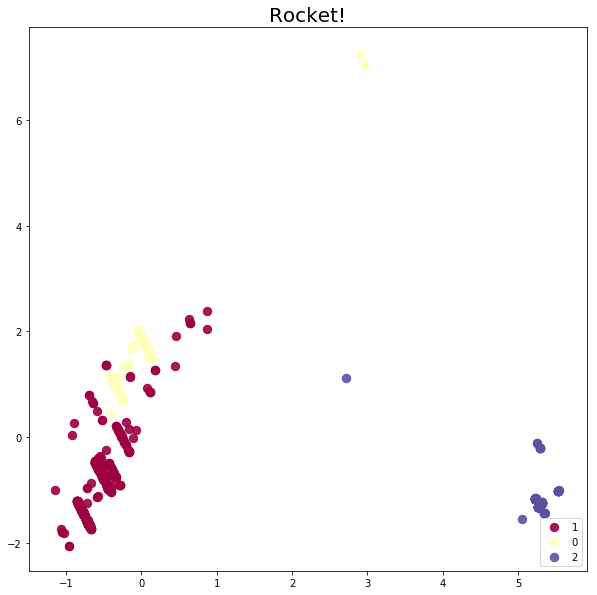

In [53]:
clusterer = KMeans(n_clusters=3)
cluster_labels = clusterer.fit_predict(XX)
XX['label'] = cluster_labels
plot_clusters(XX, 'Rocket!')

In [31]:
display(HTML(df.to_html()))